In [1]:
from importlib.metadata import version
print("torch version:", version("torch"))

torch version: 2.1.2


#### Stage 1 - **Building a LLM** 
1. Data preparation & sampling
2. ***Attention mechanism*** <----------------
3. LLM architecture

4. Pretraining

#### Stage 2 - **Foundation model**
5. Training loop 
6. Model evaluation
7. Load pretrained weights

8. Finetuning  -> dataset with class labels - classifier
              |-> instruction dataset - personal assistant



1. Simplified self-attention: A simplified self-attention technique to introduce the broader idea.
2. Self - attention: Self-attention with trainable weights that form the basis of the mechanism used in LLMs.
3. Causal attention: A type of self-attention used in LLMs that allows a model to consider only previous and current inputs in a sequence, ensuring temporal order during the text generation.
4. Multi-head attention: An extension of self-attention and casual attention that enables the model to simultaneously attend to info from different rep subspaces.

#### **Problem with modeling long sequence**
- Translating a text word by word isn't feasible due to the difference in grammatical structures between the souce and target languages

- The encoder processes a sequence of tokens from the source language, using a hidden state-- a kind of intermediate layer within the neural network -- to generate a condensed representation of the entire input sequence.
- Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all the input tokens, implying that certain input tokens hold more significance than others in the generation of specific output token
- Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence.


### Attending to different parts of the input with self-attention

#### Simple attention mechanism
- Suppose an input sequence x(1) to x(T), x(1) is a d-dimensional vector rep



In [1]:
# input seq that is embedded in 3-demensional vector

import torch 
inputs = torch.tensor([[0.43, 0.15, 0.89],    #Your
                       [0.55, 0.87, 0.66],          #journey
                       [0.57, 0.85, 0.64],    #Starts
                       [0.22, 0.58, 0.33],    #with
                       [0.77, 0.25, 0.10],    #one
                       [0.05, 0.80, 0.55]])   #step

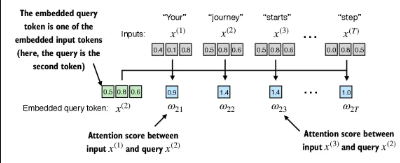

In [3]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2) 

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


### **step 2 normalize the attenton score**

In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())


Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


- however, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended
- 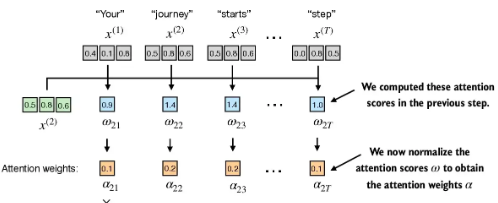

In [5]:
#naive implementation for softmax function
def softmax_func(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_softmax = softmax_func(attn_scores_2)

print("Attention weights:", attn_weights_2_softmax)
print("Sum:", attn_weights_2_softmax.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- naive implementaion above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues.
- In practice, its recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [6]:
attn_weights_2 = torch.softmax(attn_scores_2, dim = 0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


### **step 3: compute the context vector z(2)**
- by multipling the embedded input tokens, x(i) with the attention weights and sum the resulting vectors
- 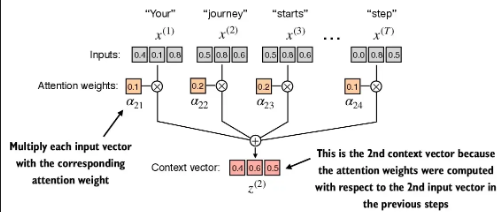

In [7]:
context_vec_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### Computing attention weights for all input tokens
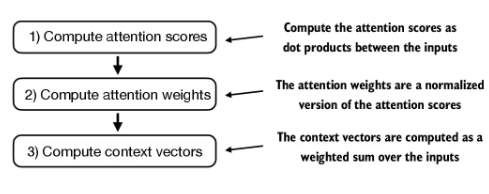

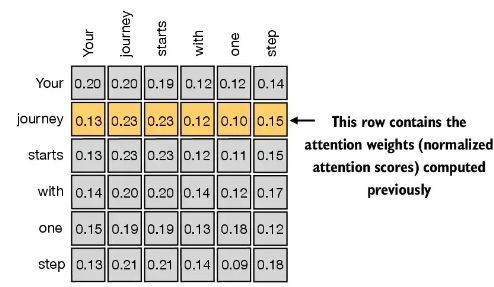

In [8]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [9]:
# We can achieve the same as above more efficiently via matrix multiplication

attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [10]:
#step 2 - normalize each row so that the values in each row sum to 1

attn_weights = torch.softmax(attn_scores, dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [11]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("all row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
all row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [12]:
#step 3  6*6  6*3

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


### **3.4 Implementing self-attention with trainable weights**

#### 3.4.1
- self attention mechanism implementation.
- also called scaled dot-product attention.
- we want to compute context vector as weighted sums over the input vectors specific to certain input elements.
  - attention weights for the above
- slightly differences compared to the basic attention mechanism.
  - notable difference is the introduction of weight matrices that are updated during model training.
  - trainable weights matrices are crucial so that the model can learn to produce "good" context vectors.

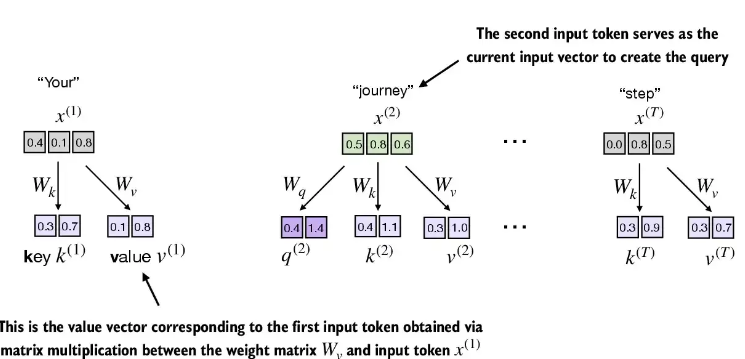
- implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrcies $W_q$, $W_k$, $W_v$
- These three matrics are used to project the embedded input tokens, $x^{(i)}$,
into query, key, value vectors via matrix multiplication:
  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$


In [13]:
x_2 = inputs[1] #second input element
d_in = inputs.shape[1] #input embedding size, d=3
d_out = 2 #output embedding size, d = 2

* Below, we initialize the three weights matrics; note that we are setting `requires_grad = False` to reduce clutter in the outputs for illustration purpose, 
but if we were to use the weight matrices for model training, we  would set `reuqires_grad = True` cto update these matrcis during model training.

In [14]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [15]:
query_2 = x_2 @ W_query
key_2   = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [16]:
keys   = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [19]:
inputs.shape, keys.shape

(torch.Size([6, 3]), torch.Size([6, 2]))

- As we can see below, we successfully projected the 6 inputs tokens from a 3D onto a 2D embedding space

- In the next step, step-2, we compute the unnormalized attention scores by computing the dot product between the query and each key vector
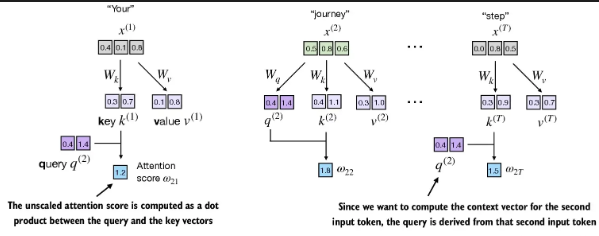

In [21]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [24]:
# Since we have 6 inputs, we have 6 attention scores for the given query vector

attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


- next step-3, we compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier.
- the difference to earlier is that we now scale the attention scores by diving them by the square root of the embedding dimension $\sqrt{d_k}$
- 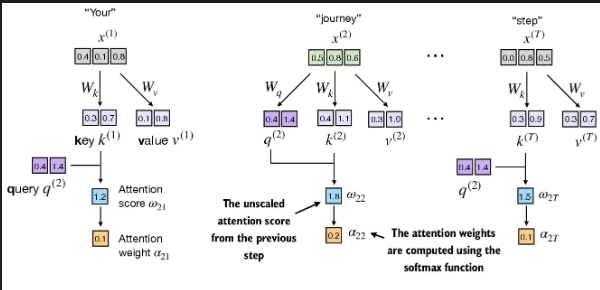

In [26]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


- step 4, we now compute the context vector for input query vector 2. 
- 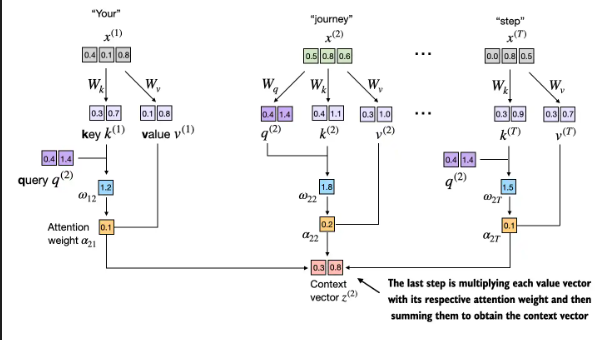

In [27]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### Impletmenting a compact SelfAttention class
- Putting it all together, we can implement the self-attention mechanism as follows.


In [35]:
import torch.nn as nn 

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys    = x @ self.W_key
        queries = x @ self.W_query
        values  = x @ self.W_value
        
        attn_scores  = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = 1)

        context_vec =attn_weights @ values
        return context_vec

In [37]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1.forward(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [38]:
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


- 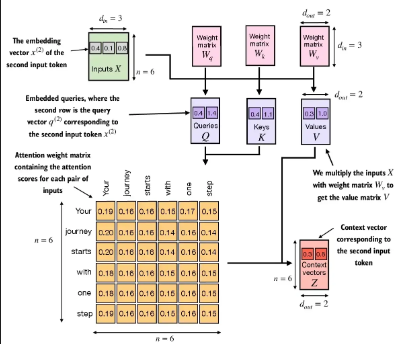

- We can steamline the implementation above using PyTorch linear layers, which are equvivalent to a matrix multiplication if we disable the bias unit
- Another big advantave of using nn.Linear over out manial nn.Parameter(torch.rand()) approach is that nn.Linear has a preferred weight initialization scheme, which leads to more stable model training.

In [39]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


- Note that SelfAttention_v1 , SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices